# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте эти файлы [на странице задания](https://www.coursera.org/learn/data-analysis-project/peer/roSOe/opisatiel-nyi-analiz-dannykh) и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/double_dee/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
X_train = pd.read_csv('orange_small_churn_data.train')
y_train = pd.read_csv('orange_small_churn_labels.train', header=None)

In [3]:
y_train.columns = ['churn']

2\. Рассчитайте доли классов `отток` и `не отток`.

In [4]:
y_train['churn'].value_counts()

-1    37024
 1     2976
Name: churn, dtype: int64

In [5]:
print('Доля класса не отток: ', 37024/(37024+2976))
print('Доля класса  отток: ', (1-37024/(37024+2976)))

Доля класса не отток:  0.9256
Доля класса  отток:  0.07440000000000002


3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://www.coursera.org/teach/stats-for-data-analysis/content/edit/lecture/prX3S/video-subtitles 

Из условия: Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными):

In [6]:
data_num = X_train.iloc[:, :190]
data_num['churn'] = y_train
data_cat = X_train.iloc[:, 190:]
data_cat['churn'] = y_train

In [7]:
data_num.fillna(0, inplace=True)
#заменим пустые значения на '0'

In [8]:
# для числовых и биноминальных переменных корреляция считается по формуле mean(feature(1))-mean(feature(-1))
num_corr_binom = np.abs(data_num.loc[y_train[y_train['churn'] == 1].index].mean() - 
                         data_num.loc[y_train[y_train['churn'] == -1].index].mean())
num_corr_binom.head()

Var1       0.009670
Var2       0.000135
Var3       7.659134
Var4       0.001838
Var5    4069.214919
dtype: float64

In [25]:
num_corr = pd.DataFrame(zip(data_num.columns, num_corr_binom), columns = ['feature', 'corr'])

In [26]:
num_corr.head()

,feature,corr
0,Var1,0.009670
1,Var2,0.000135
2,Var3,7.659134
3,Var4,0.001838
4,Var5,4069.214919


In [59]:
print('Корреляция самых "сильных" вещественных признаков \n', 
      num_corr.sort_values(by='corr', ascending=False)[:5])

Корреляция самых "сильных" вещественных признаков 
     feature           corr
152  Var153  392543.476236
37    Var38  177037.680164
112  Var113  162842.184538
75    Var76  113461.719515
130  Var131  112199.915256


Для подсчета корреляции  категориальных и биноминальных переменных, используется коэф-нт Крамера

In [10]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [13]:
cramers_stats = []

for name in data_cat.columns:
    if data_cat[name].isnull().sum() != len(data_cat):
        cramers_stats.append(cramers_v(data_cat[name], y_train['churn']))
    else:
        cramers_stats.append(np.nan)

/home/double_dee/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [22]:
cat_corr_binom = pd.DataFrame(zip(data_cat.columns, cramers_stats), columns = ['feature', 'cramer_V'])
cat_corr_binom.set_index('feature', inplace = True)
cat_corr_binom.sort_values(by = 'cramer_V', inplace = True, ascending = False)
cat_corr_binom.head(6)

,cramer_V
feature,
churn,0.999818
Var199,0.237375
Var192,0.116264
Var216,0.083442
Var206,0.077436
Var212,0.075150


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

/home/double_dee/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/double_dee/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


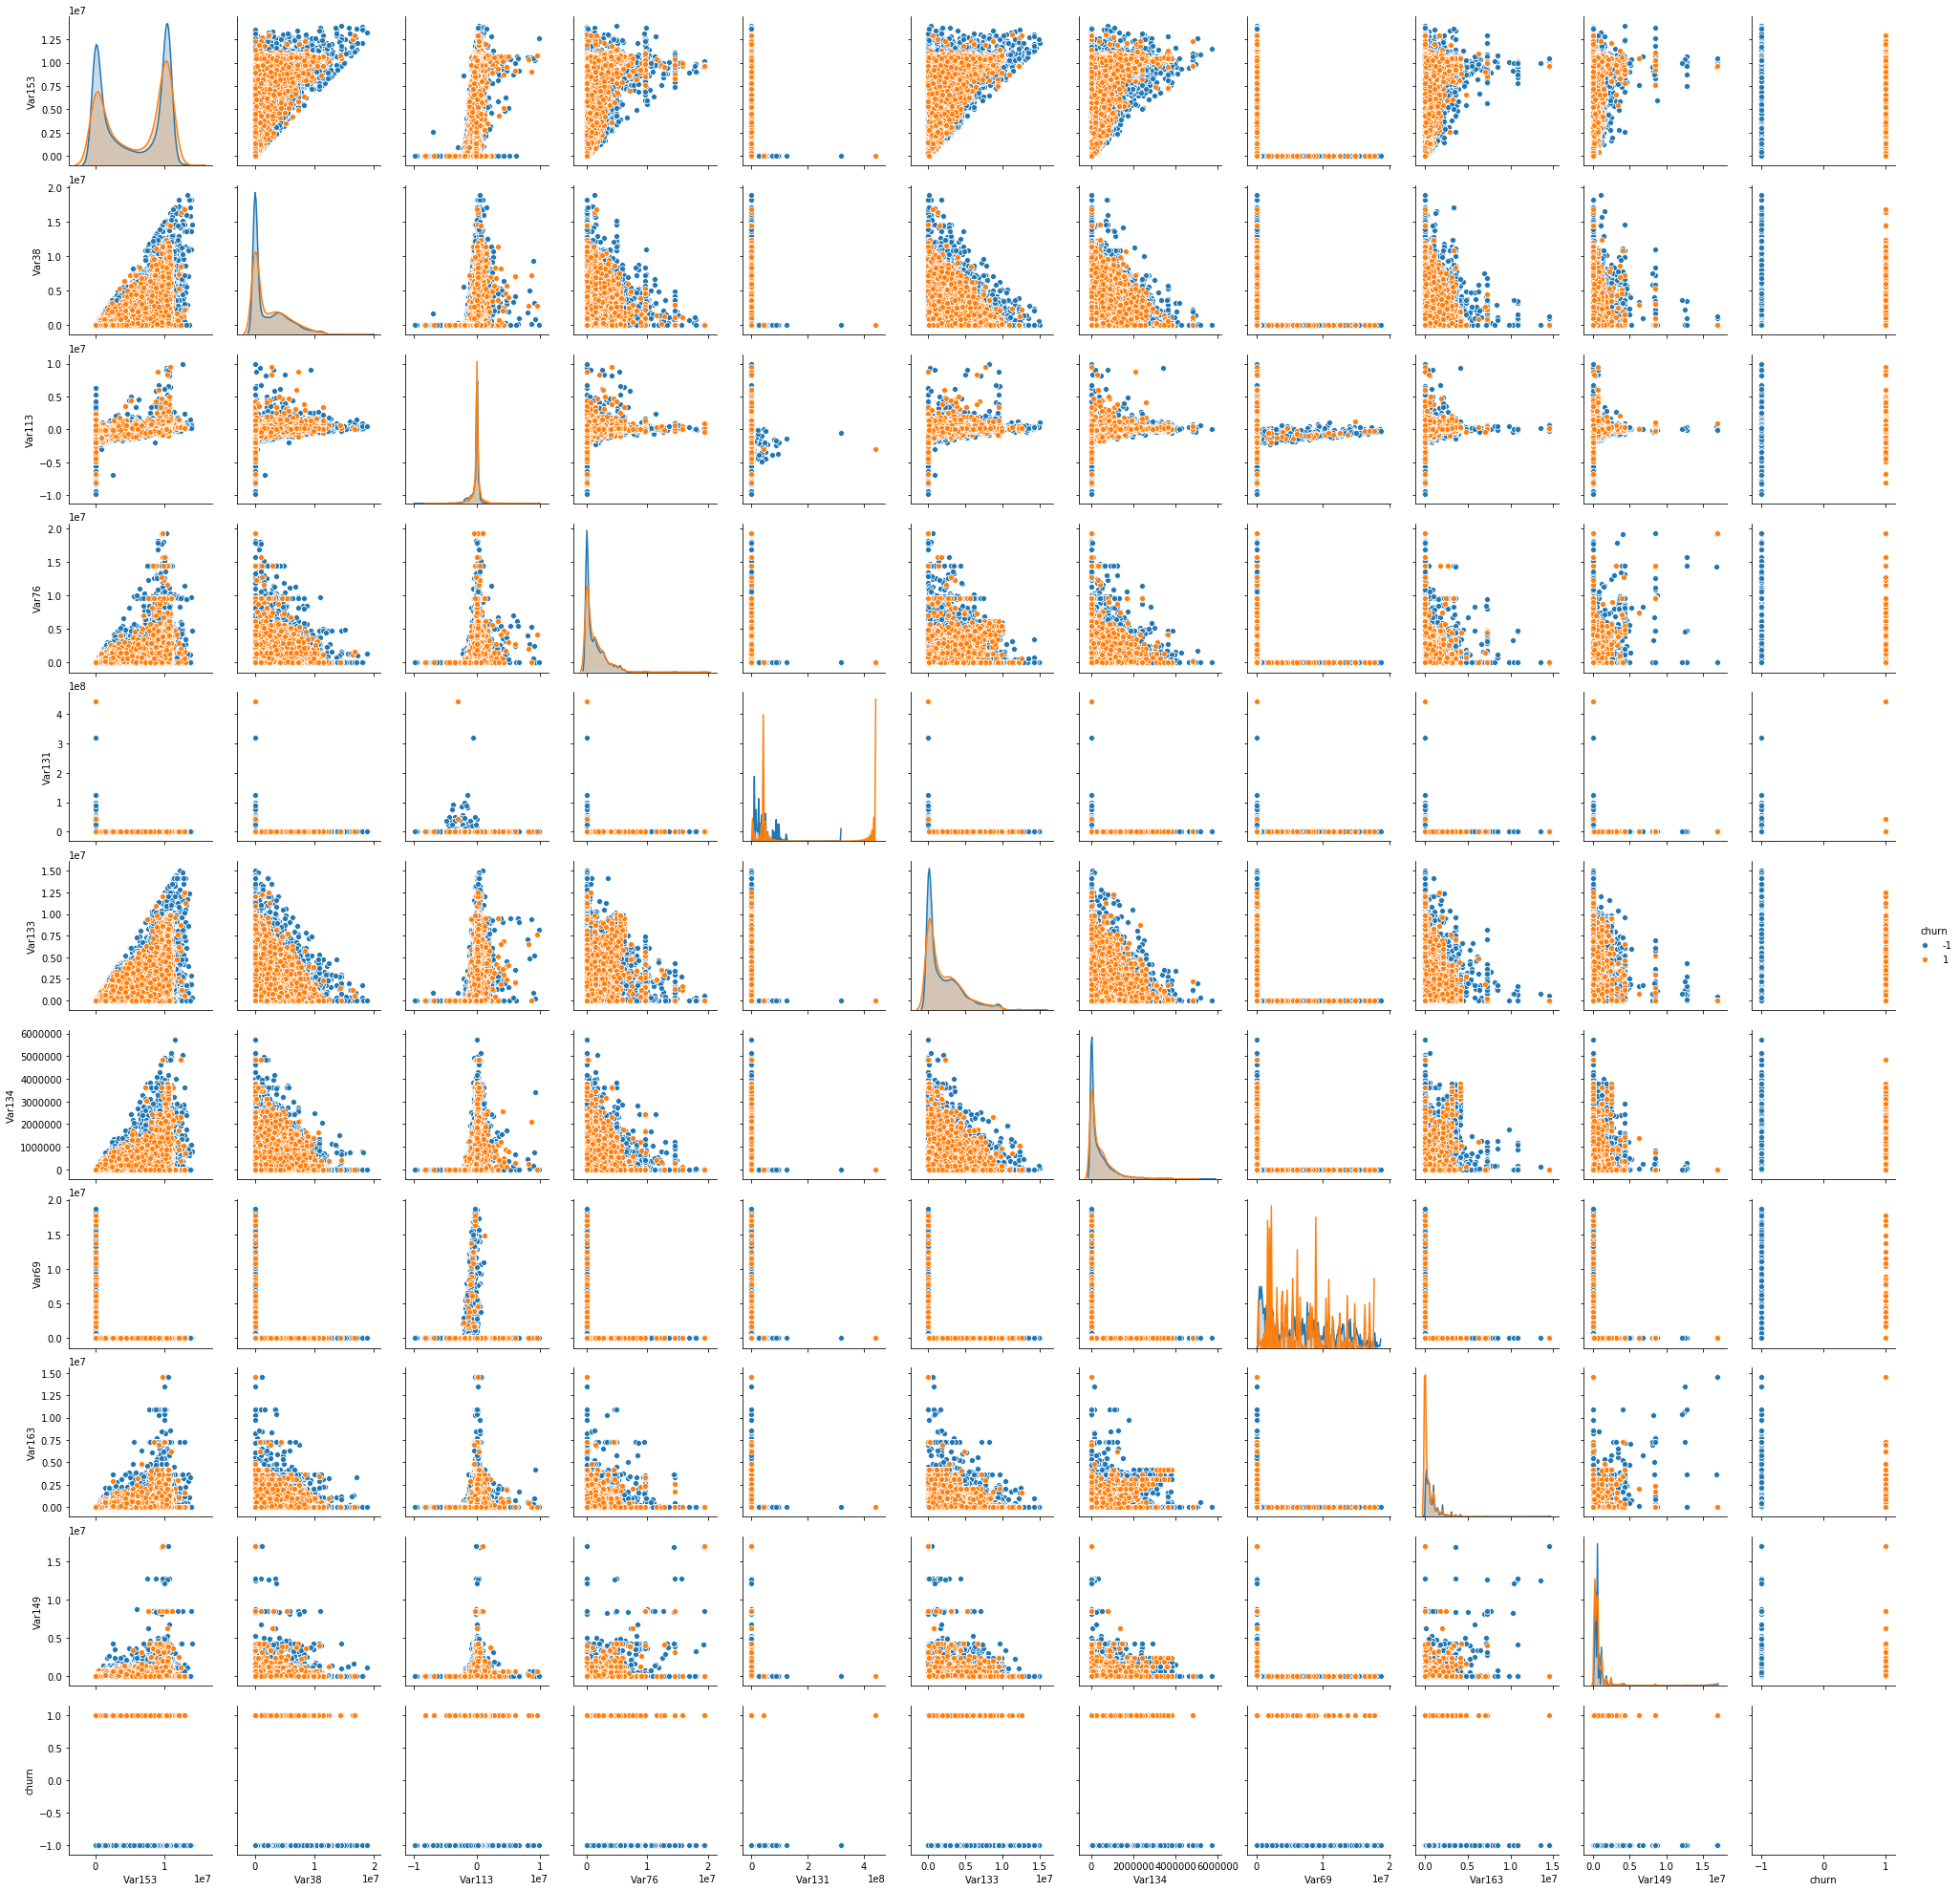

In [42]:
#делал по 10 признакам из-за нехватки памяти
top10_corr = num_corr.sort_values(by='corr', ascending=False)[:10]
columns = top10_corr.feature.iloc[:10]
columns[len(columns)] = ("churn")
sns.pairplot(data_num[columns], hue="churn")

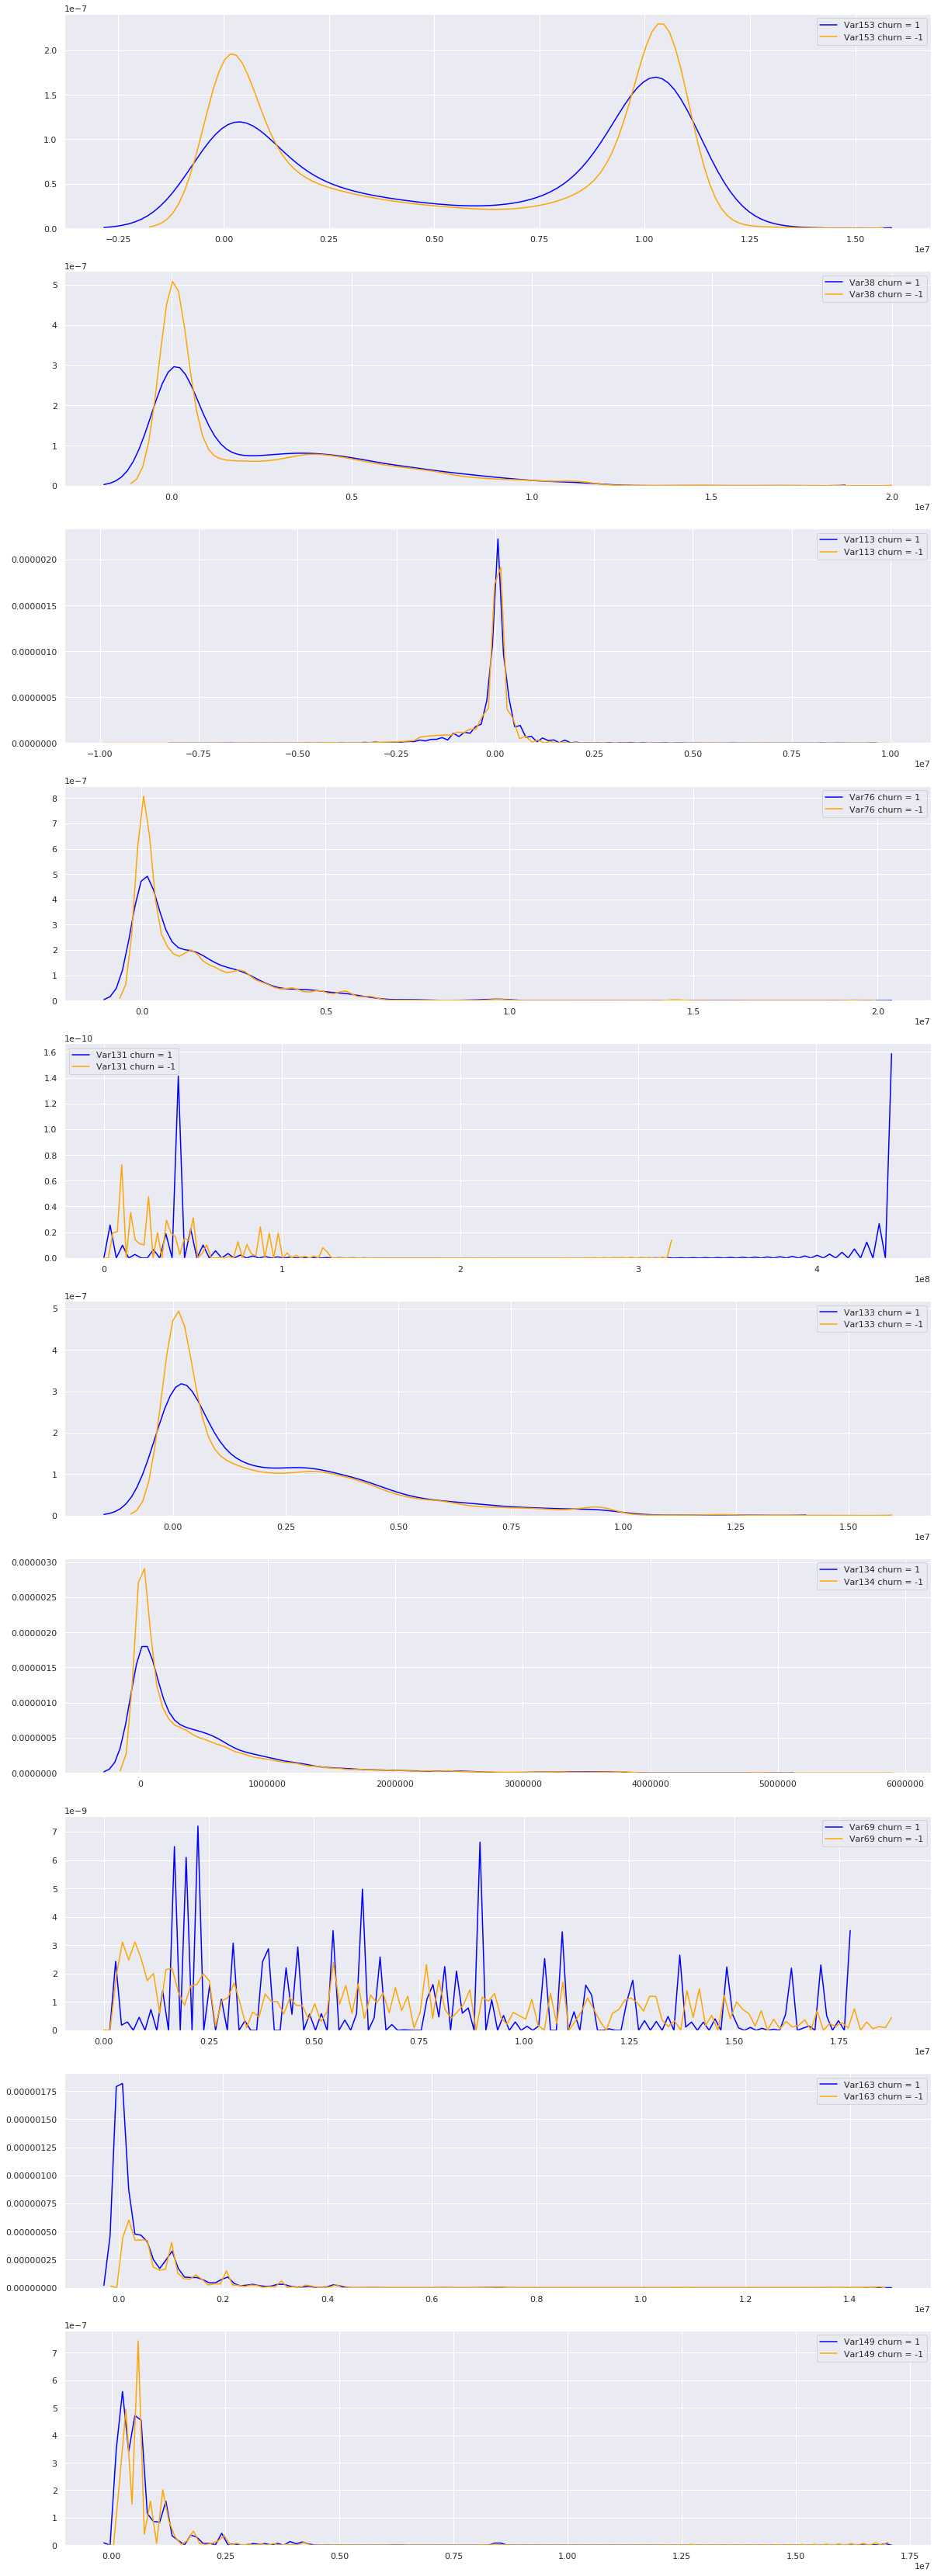

In [48]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs, columns):
    sns.kdeplot(data_num[column][data_num['churn'] == 1],
                ax = ax, color = "blue", label = str(column)+" churn = 1")
    sns.kdeplot(data_num[column][data_num['churn'] == -1], 
                ax = ax, color = "orange", label = str(column)+" churn = -1")

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

In [94]:
num_corr.iloc[random_features, 0]

171    Var172
154    Var155
112    Var113
26      Var27
129    Var130
52      Var53
43      Var44
20      Var21
164    Var165
73      Var74
Name: feature, dtype: object

In [95]:
np.random.RandomState(0)
random_features = np.random.randint(50, size = 10)
columns = num_corr.iloc[random_features, 0]
columns[len(columns)] = ("churn")
columns

20    Var21
3      Var4
36    Var37
3      Var4
30    Var31
13    Var14
8      Var9
15    Var16
11    Var12
18    Var19
10    churn
Name: feature, dtype: object

In [ ]:
columns[len(columns)] = ("churn")
sns.pairplot(data_num[columns], hue="churn")

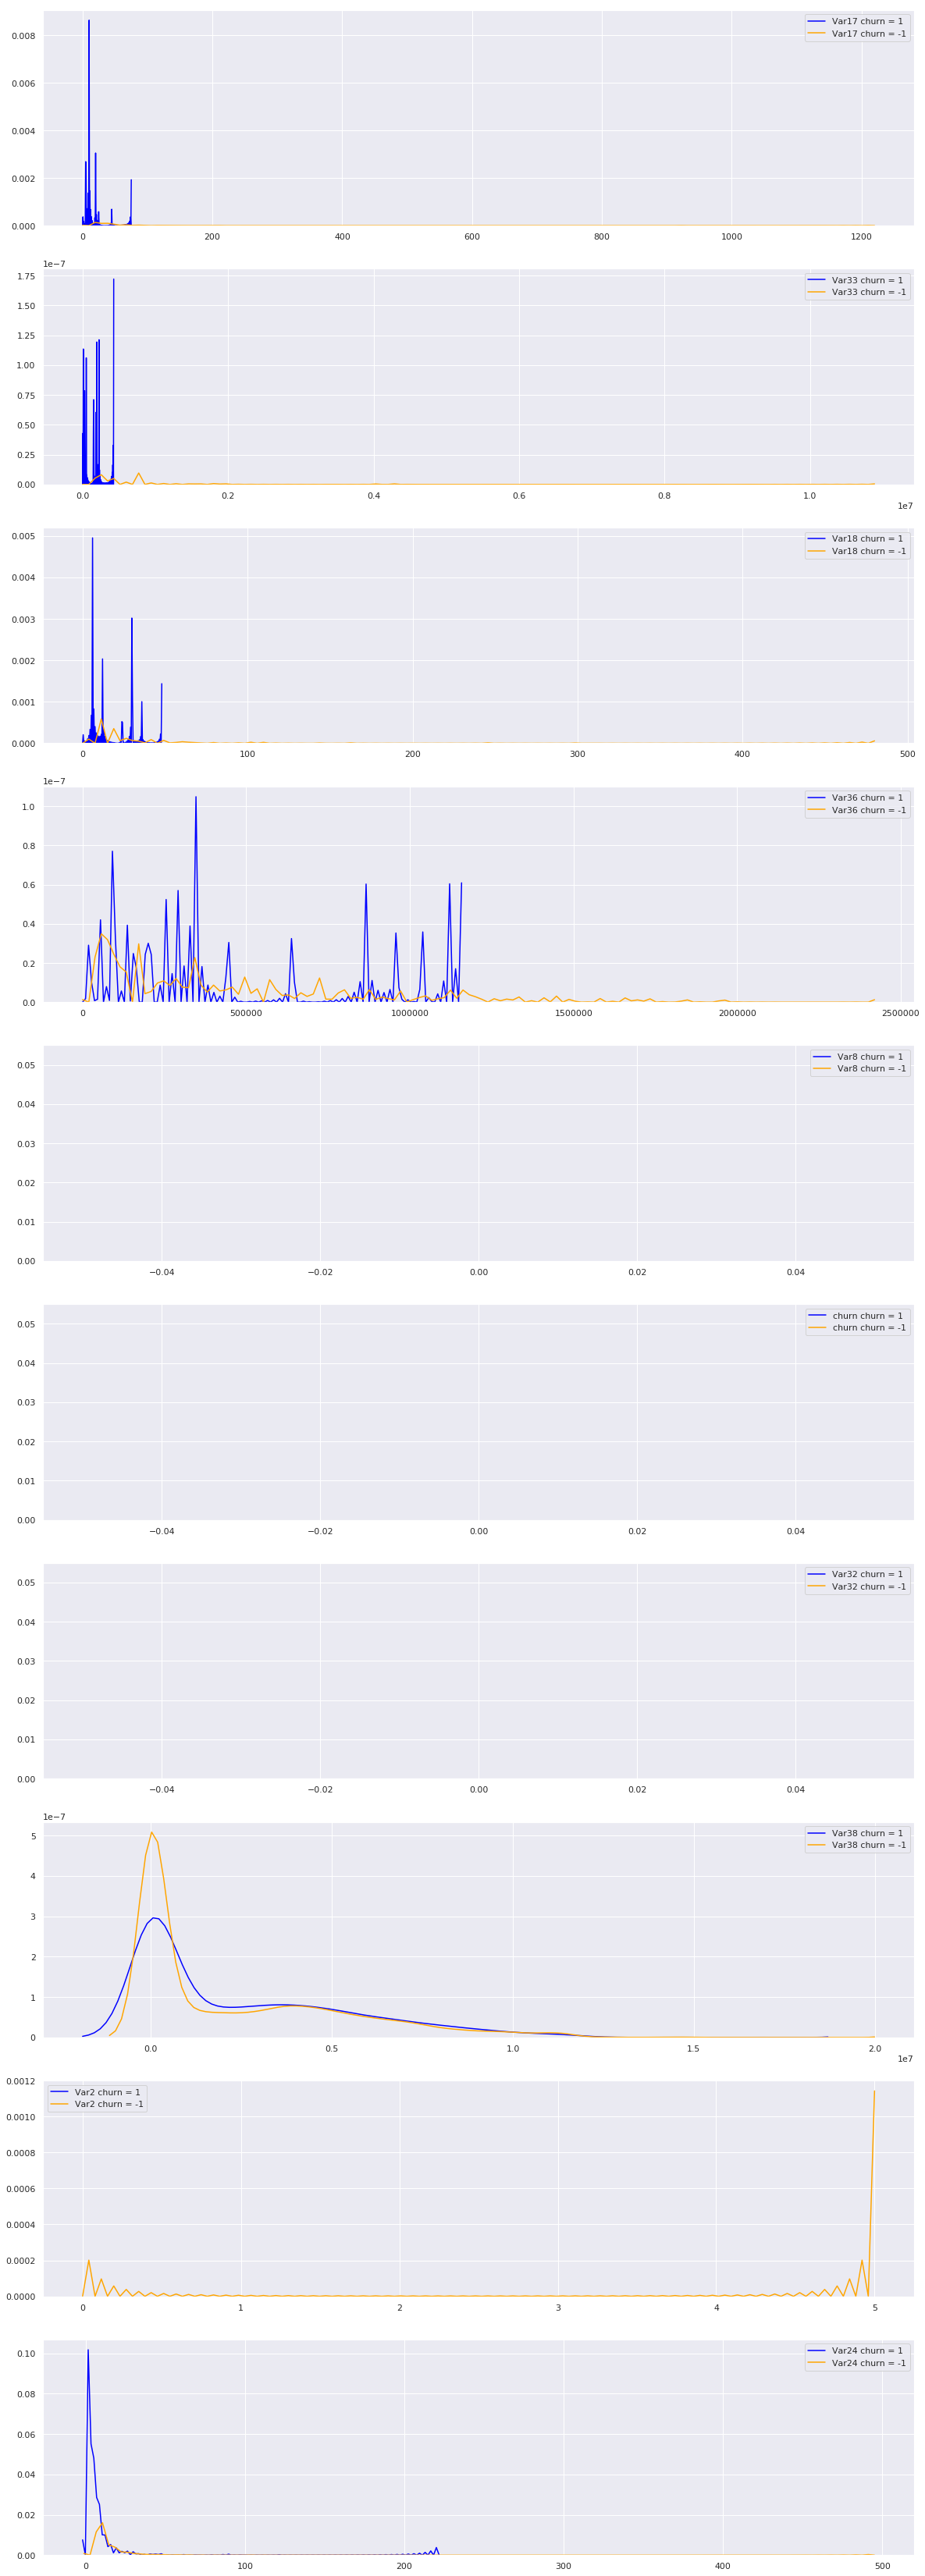

In [71]:
ig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs, columns):
    sns.kdeplot(data_num[column][data_num['churn'] == 1],
                ax = ax, color = "blue", label = str(column)+" churn = 1")
    sns.kdeplot(data_num[column][data_num['churn'] == -1], 
                ax = ax, color = "orange", label = str(column)+" churn = -1")

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

/home/double_dee/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/double_dee/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


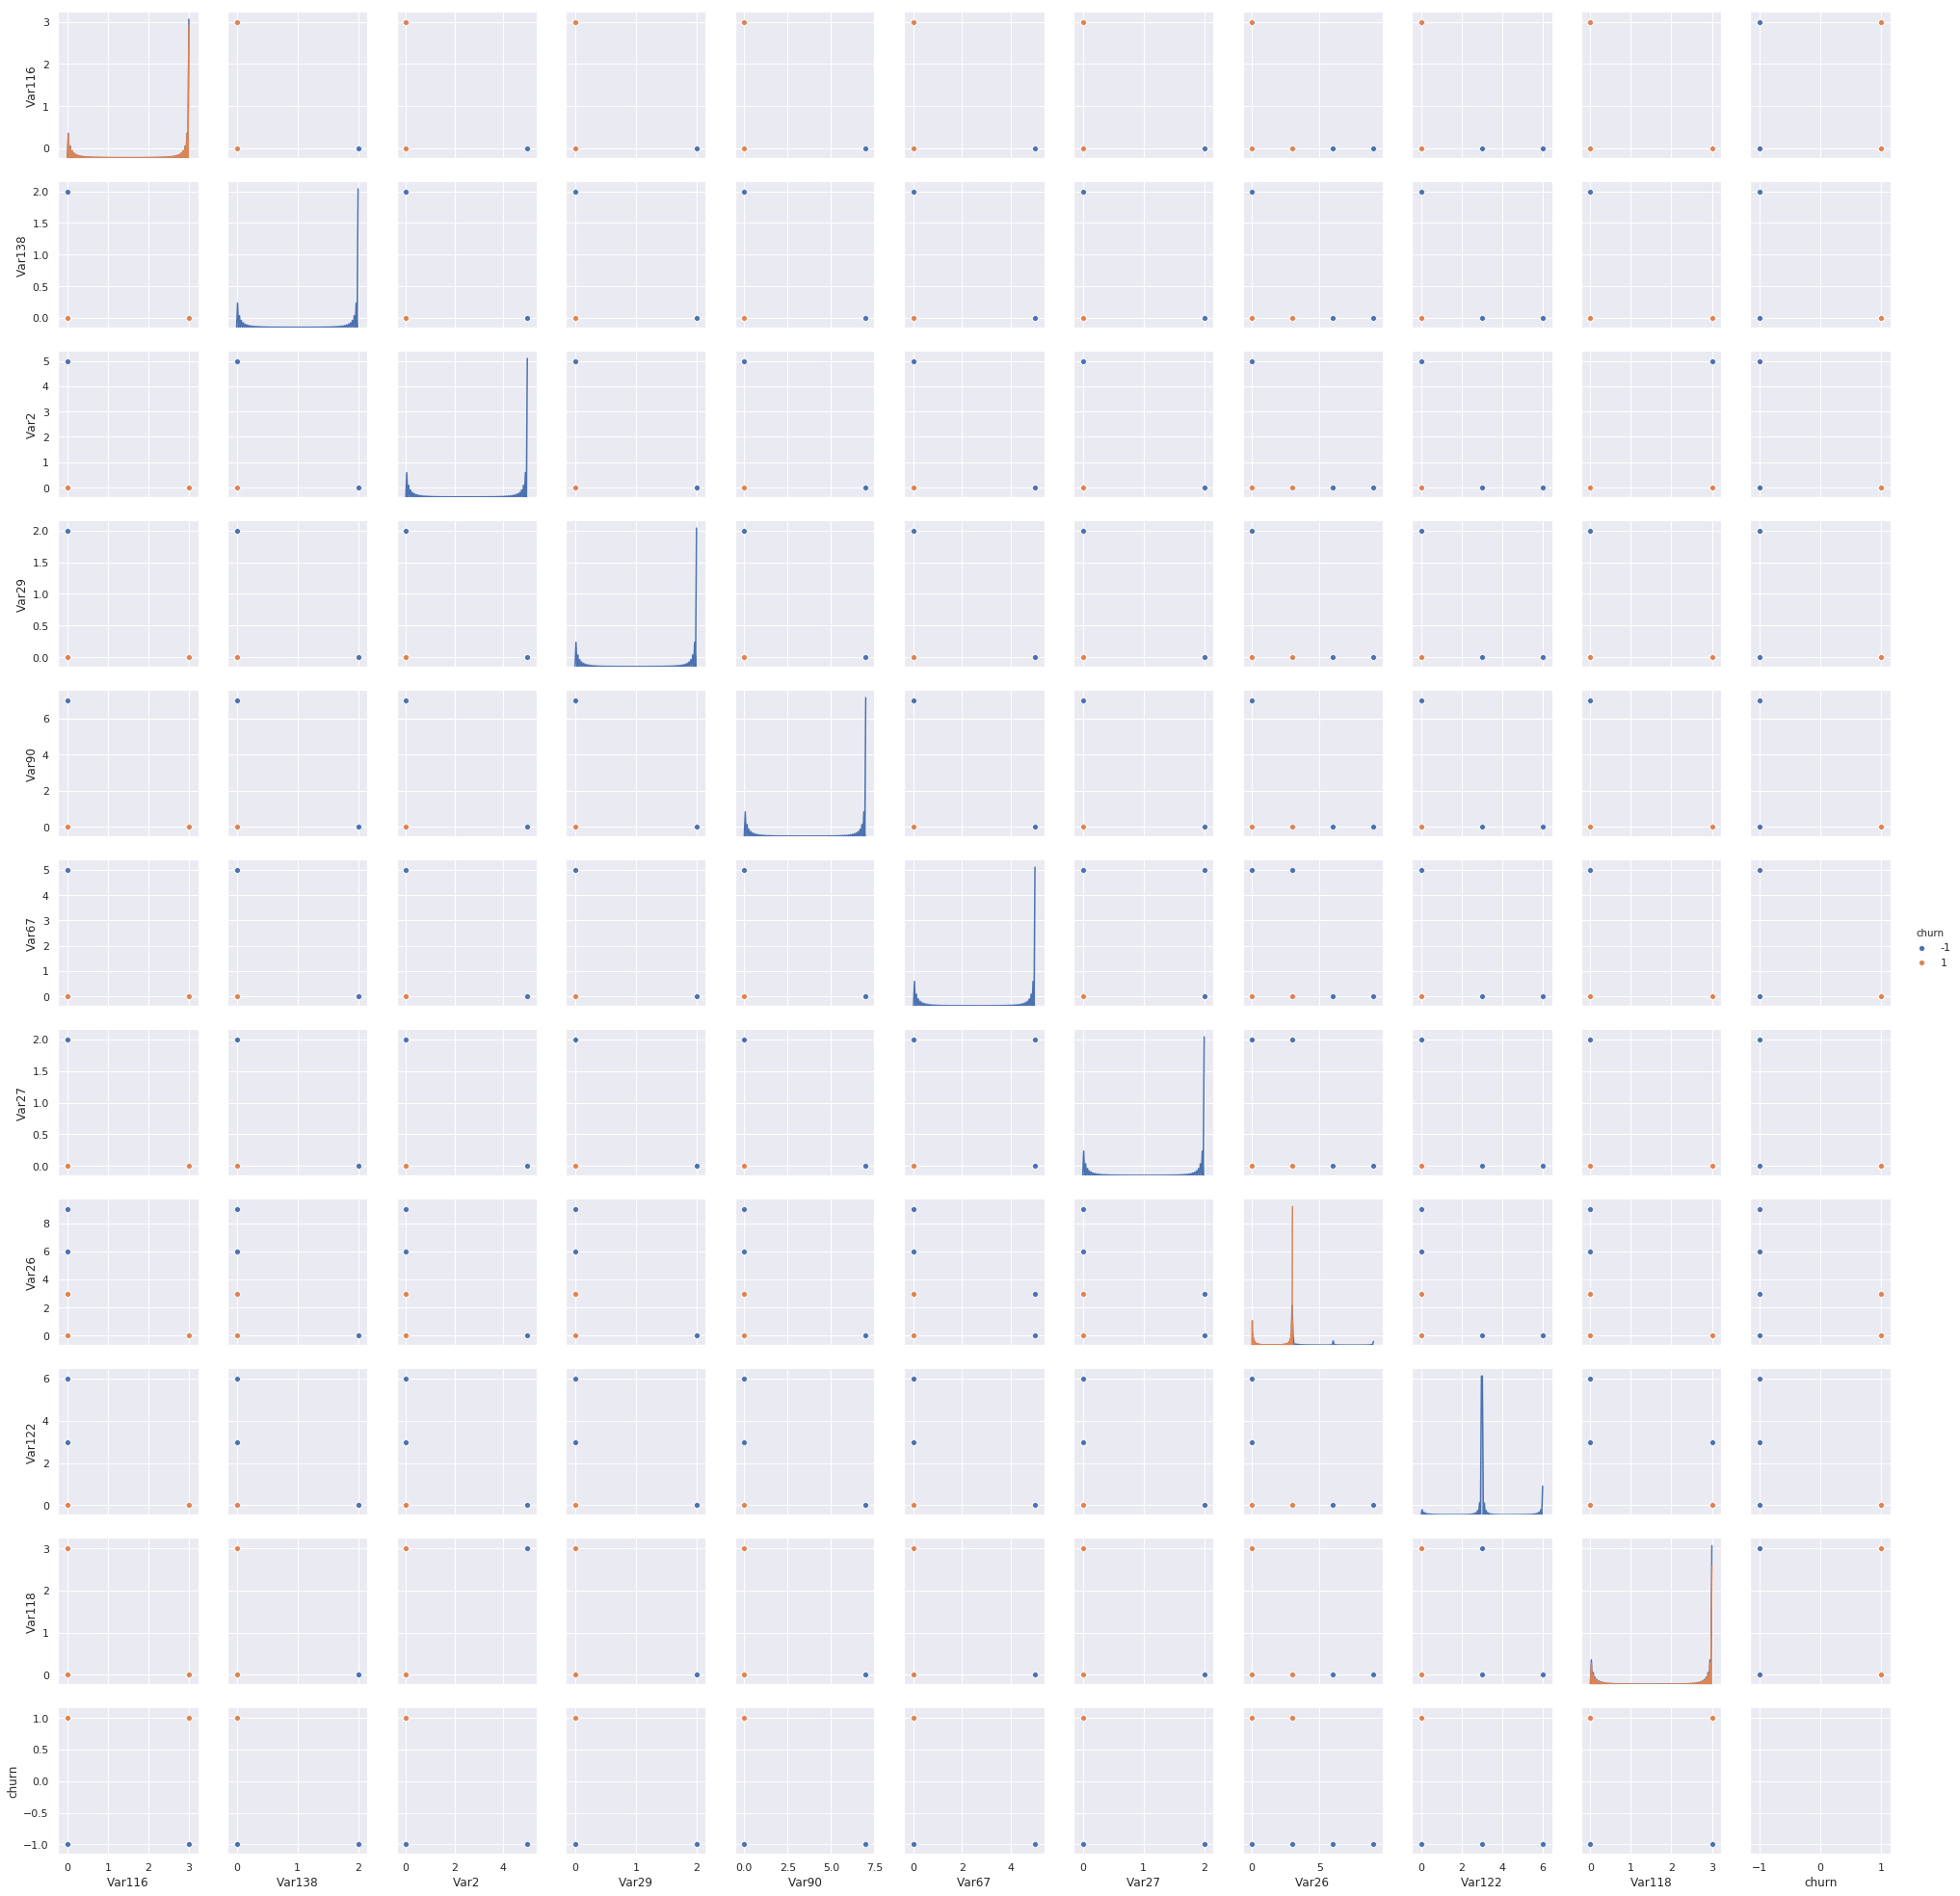

In [56]:
low10_corr = num_corr[num_corr['corr'] > 0].sort_values(by='corr', ascending=True)[:10]
columns = low10_corr.feature.iloc[:10]
columns[len(columns)] = ("churn")
sns.pairplot(data_num[columns], hue="churn")

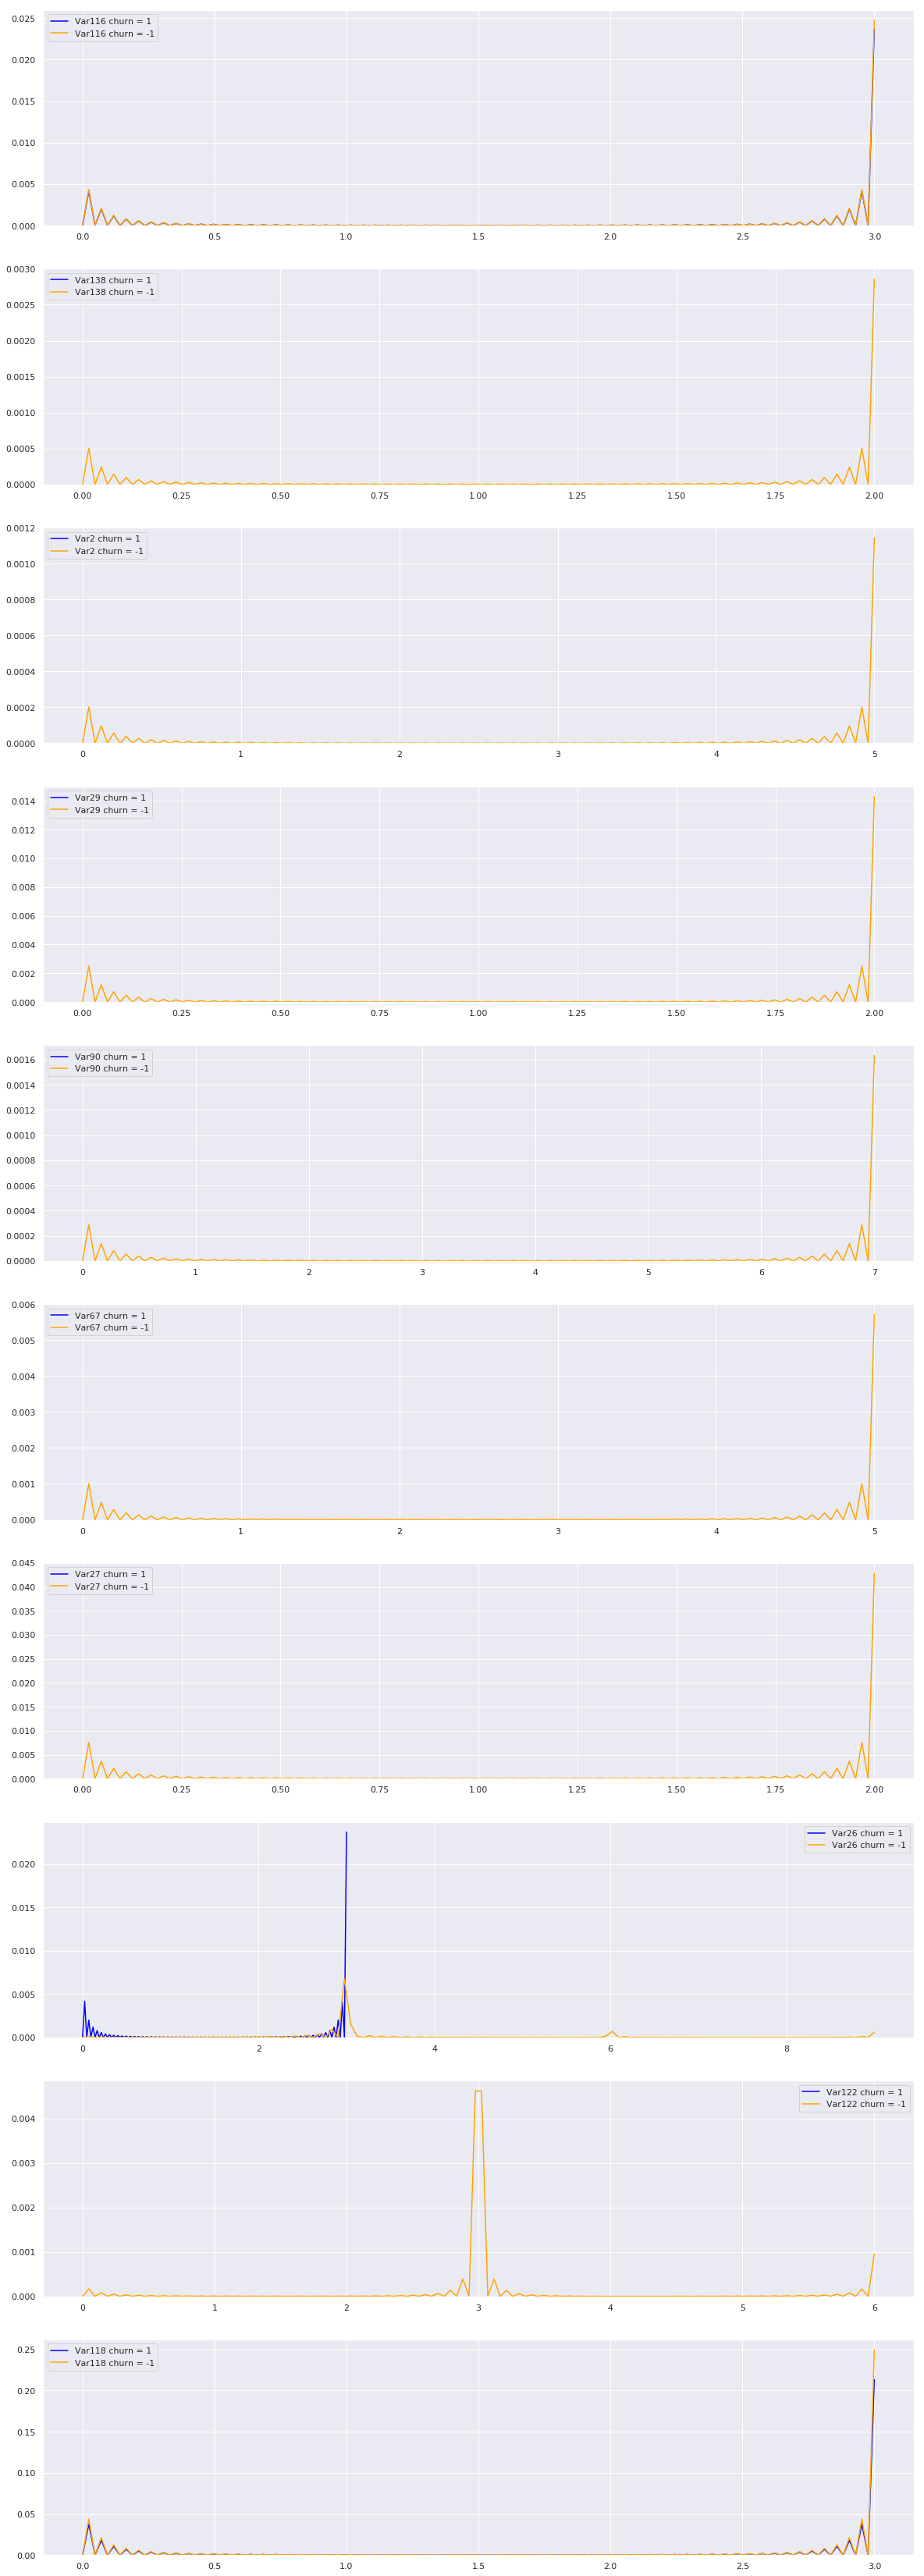

In [57]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs, columns):
    sns.kdeplot(data_num[column][data_num['churn'] == 1],
                ax = ax, color = "blue", label = str(column)+" churn = 1")
    sns.kdeplot(data_num[column][data_num['churn'] == -1], 
                ax = ax, color = "orange", label = str(column)+" churn = -1")

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

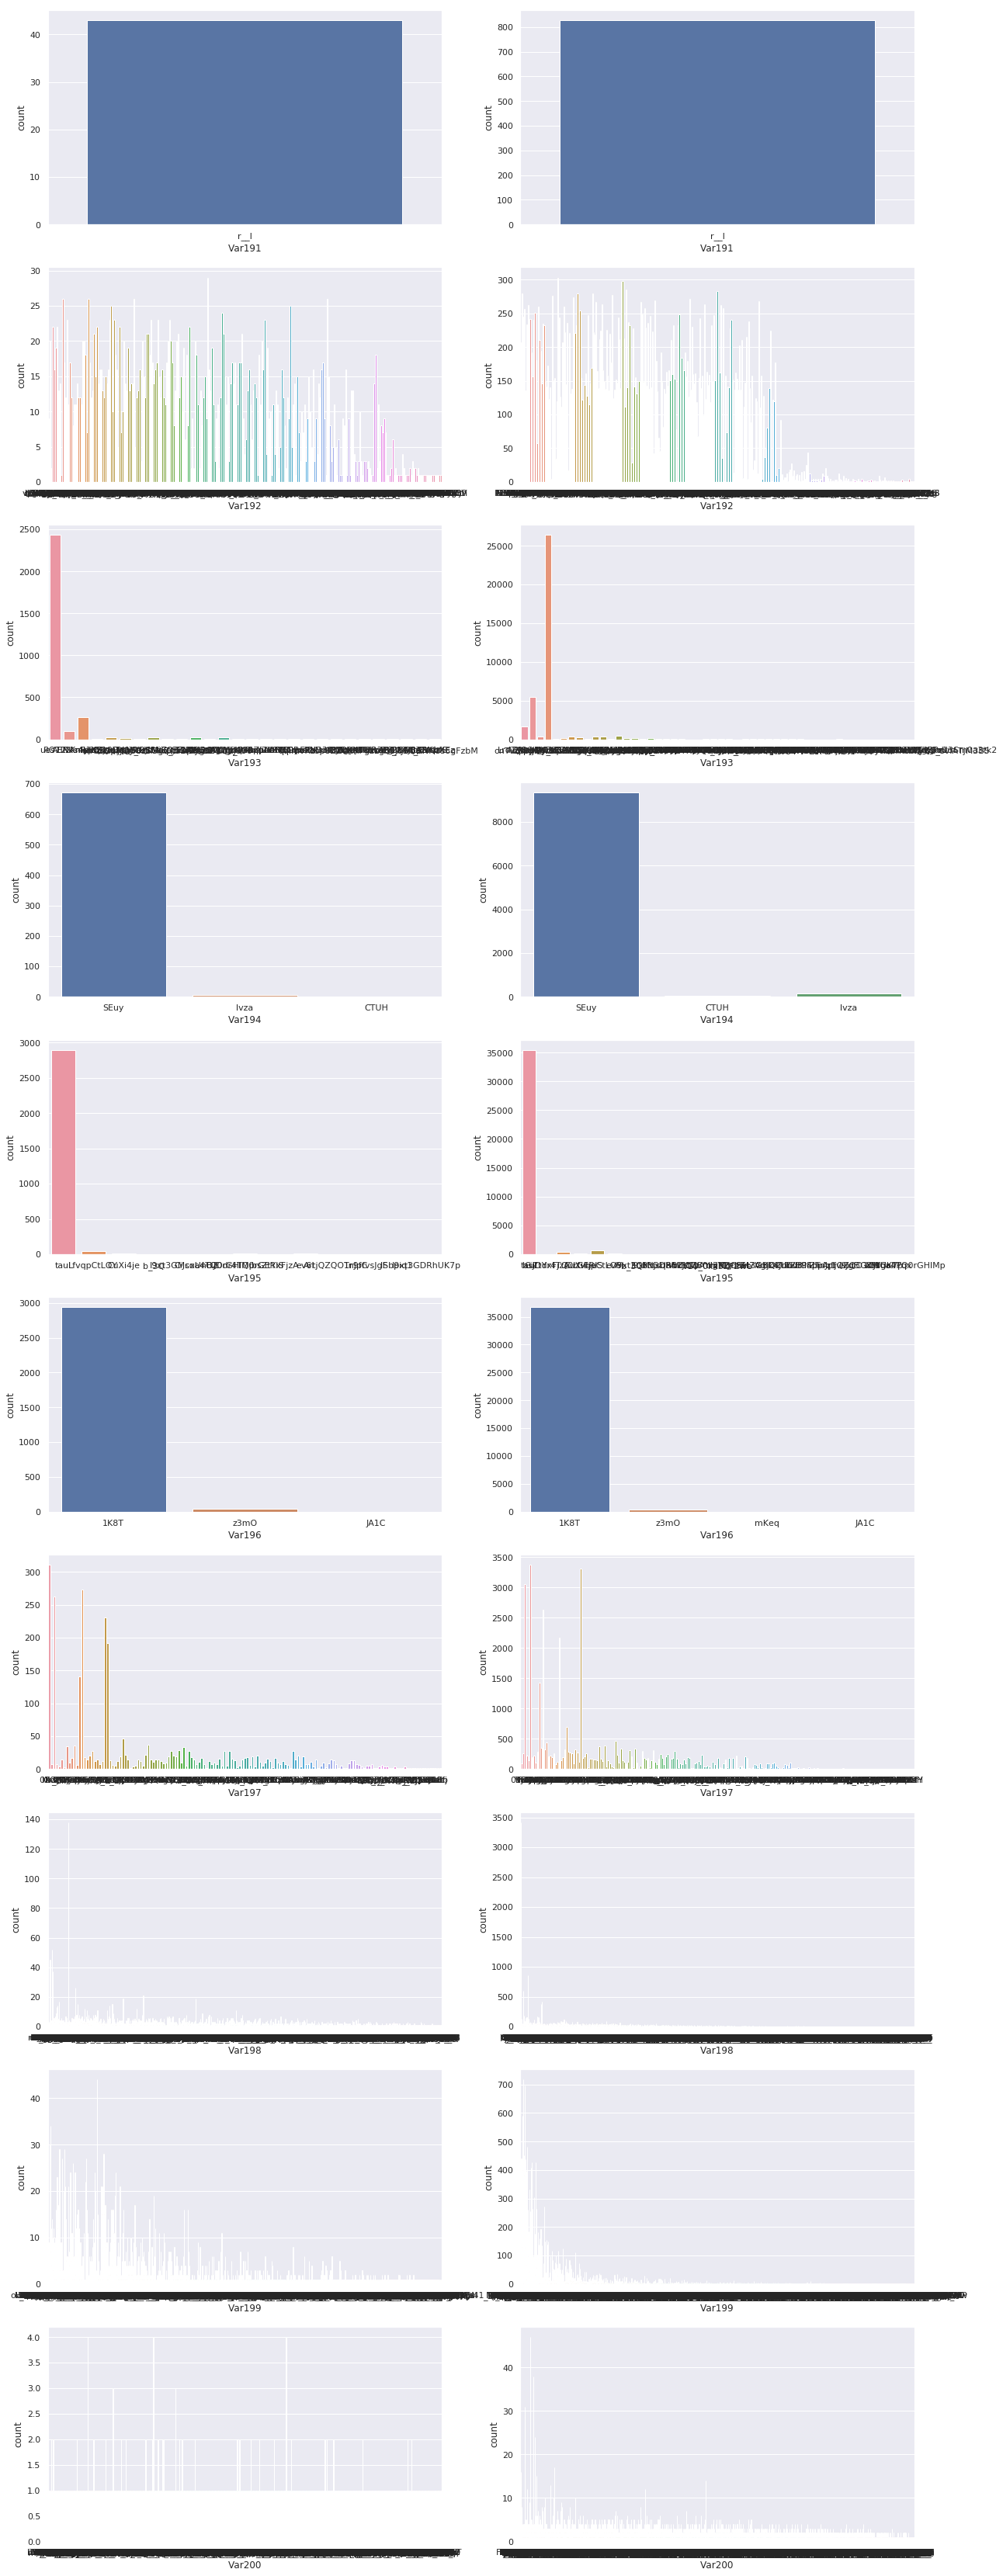

In [58]:
fig, axs = plt.subplots(10,2, figsize = (20,60))
for y in range(10):
    sns.countplot(data_cat.iloc[:, y][data_cat['churn'] == 1], ax = axs[y,0])
    sns.countplot(data_cat.iloc[:, y][data_cat['churn'] == -1], ax = axs[y,1])

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности? 

Большинство признаков, скорее всего, не будут информативными, т.к. имеют очень много пропусков. В большинстве числовых признаков, в которых мало пропусков, видны четкие различия в распредилении плотности по целевой переменной.
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?

Из категориальных Var193, 
из вещественных наиболее коррелируемые с целевой переменной Var153, Var38, Var113, Var 136
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?

Наимение полезными будут все числовые переменные, в которых большое число пропусков.
* Как вы думаете, окажется ли отбор признаков полезным для построения модели?

Отбор признаков будет полезен для построения моделей.